In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display, Markdown
from matplotlib.colors import LinearSegmentedColormap

# Custom palette (8 colors)
PALETTE = [
    "#b30047", "#ff4dc4", "#b30086", "#d580ff",
    "#0000e6", "#9999ff", "#85e0e0", "#009973"
]

def section(title: str):
    """Pretty section headers for Jupyter."""
    display(Markdown(f"---\n## {title}\n---"))

sns.set_theme(style="whitegrid")

In [16]:
DATA_PATH = "alzheimers_disease_data.csv"  # change to full path if needed

# Quick helper to show where Jupyter is currently running from
print("Current working directory:", os.getcwd())

df = pd.read_csv(DATA_PATH)
print("Dataset shape (rows, cols):", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Current working directory: c:\Users\Hanna\final proj
Dataset shape (rows, cols): (2149, 35)
Columns: ['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis', 'DoctorInCharge']


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


## 2) Preprocessing / feature encoding

Seaborn plots and stats tests work best when:
- categorical yes/no fields are encoded to numeric (0/1)
- Diagnosis is encoded to `Diagnosis_bin` (0 = no AD, 1 = AD)

This section creates:
- `Smoking_bin` (0/1)
- `MemoryComplaints_bin` (0/1)
- `Diagnosis_bin` (0/1)
- `EducationLevel_num` (optional numeric ordering, only if EducationLevel is text)

We also drop rows where the mapping fails (e.g., unexpected values).

In [17]:
def to_binary(series: pd.Series) -> pd.Series:
    """
    Map common yes/no strings to 1/0.
    If the series is already numeric, coerce to numeric (handles 0/1, 0.0/1.0).
    """
    if pd.api.types.is_numeric_dtype(series):
        return pd.to_numeric(series, errors="coerce")

    s = series.astype(str).str.strip().str.lower()
    mapping = {
        # yes-like
        "yes": 1, "y": 1, "true": 1, "1": 1,
        "smoker": 1, "current": 1,

        # no-like
        "no": 0, "n": 0, "false": 0, "0": 0,
        "non-smoker": 0, "nonsmoker": 0, "never": 0
    }
    return s.map(mapping)

# --- Smoking_bin ---
df["Smoking_bin"] = to_binary(df["Smoking"]) if "Smoking" in df.columns else np.nan

# --- MemoryComplaints_bin ---
df["MemoryComplaints_bin"] = to_binary(df["MemoryComplaints"]) if "MemoryComplaints" in df.columns else np.nan

# --- Diagnosis_bin ---
if "Diagnosis" in df.columns:
    if pd.api.types.is_numeric_dtype(df["Diagnosis"]):
        df["Diagnosis_bin"] = pd.to_numeric(df["Diagnosis"], errors="coerce")
    else:
        s = df["Diagnosis"].astype(str).str.strip().str.lower()
        diag_map = {
            "alzheimers": 1, "alzheimer": 1, "alzheimer's": 1, "ad": 1, "1": 1, "positive": 1,
            "control": 0, "healthy": 0, "no": 0, "0": 0, "negative": 0
        }
        df["Diagnosis_bin"] = s.map(diag_map)

# Drop rows where we cannot interpret Diagnosis
df = df.dropna(subset=["Diagnosis_bin"]).copy()
df["Diagnosis_bin"] = df["Diagnosis_bin"].astype(int)

# Drop rows where Smoking / MemoryComplaints mapping failed (optional but keeps plots clean)
for col in ["Smoking_bin", "MemoryComplaints_bin"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df = df.dropna(subset=[col]).copy()
        df[col] = df[col].astype(int)

if "EducationLevel" in df.columns:
    if not pd.api.types.is_numeric_dtype(df["EducationLevel"]):
        edu_order = {
            "none": 0, "primary": 1, "middle": 2, "highschool": 3,
            "diploma": 4, "bachelor": 5, "master": 6, "phd": 7
        }
        df["EducationLevel_num"] = df["EducationLevel"].astype(str).str.strip().str.lower().map(edu_order)
    else:
        df["EducationLevel_num"] = pd.to_numeric(df["EducationLevel"], errors="coerce")

print("After preprocessing shape:", df.shape)
print("\nSmoking_bin counts:\n", df["Smoking_bin"].value_counts(dropna=False))
print("\nDiagnosis_bin counts:\n", df["Diagnosis_bin"].value_counts(dropna=False))
print("\nMemoryComplaints_bin counts:\n", df["MemoryComplaints_bin"].value_counts(dropna=False))

After preprocessing shape: (2149, 39)

Smoking_bin counts:
 Smoking_bin
0    1529
1     620
Name: count, dtype: int64

Diagnosis_bin counts:
 Diagnosis_bin
0    1389
1     760
Name: count, dtype: int64

MemoryComplaints_bin counts:
 MemoryComplaints_bin
0    1702
1     447
Name: count, dtype: int64


## 3) Visualizations to answer the different hypothesises.

### Q1: Lifestyle habits (smoking, physical activity) vs AD diagnosis
### Q2: Education level vs cognitive performance (MMSE)
### Q3: Sleep quality vs memory complaints

hypothesis 1:
 We hypothesize that modifiable lifestyle factors (specifically smoking and low physical activity) will show a statistically significant correlation with a higher probability of Alzheimer's diagnosis.

---
## Smoking vs Diagnosis
---

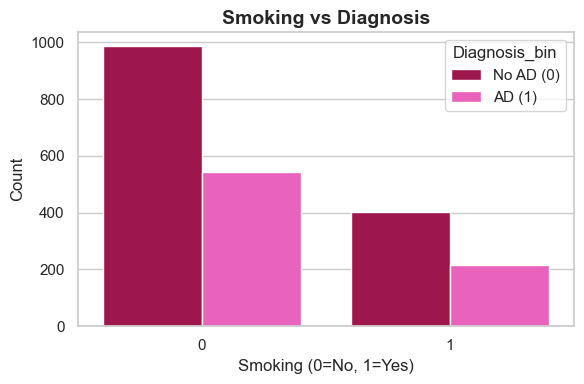

In [18]:
section("Smoking vs Diagnosis")
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Smoking_bin", hue="Diagnosis_bin", palette=PALETTE[:2])
plt.title("Smoking vs Diagnosis", fontsize=14, fontweight='bold')
plt.xlabel("Smoking (0=No, 1=Yes)")
plt.ylabel("Count")
plt.legend(title="Diagnosis_bin", labels=["No AD (0)", "AD (1)"])
plt.tight_layout()
plt.show()

---
## AD Rate by Smoking (Likelihood)
---

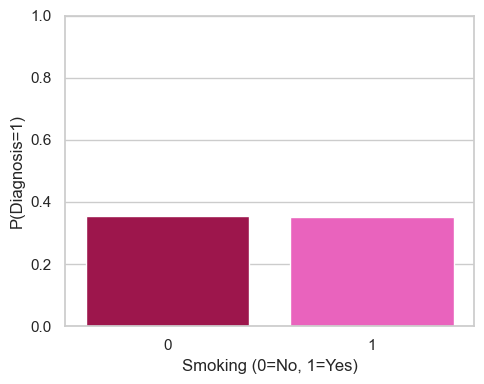

In [19]:
section("AD Rate by Smoking (Likelihood)")
# Mean of Diagnosis_bin = proportion of AD cases in each smoking group
rate = df.groupby("Smoking_bin")["Diagnosis_bin"].mean().reset_index()

plt.figure(figsize=(5,4))
sns.barplot(data=rate, x="Smoking_bin", y="Diagnosis_bin", hue="Smoking_bin", palette=PALETTE[:2], legend=False)
plt.xlabel("Smoking (0=No, 1=Yes)")
plt.ylabel("P(Diagnosis=1)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

C:\Users\Hanna\AppData\Local\Temp\ipykernel_6236\3070984305.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


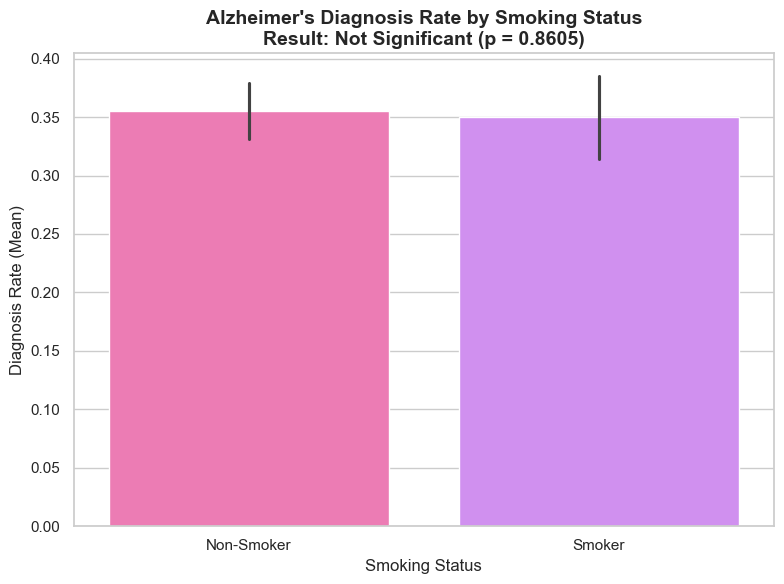

In [20]:
#Statistical Calculation (Chi-square test)
#We use Chi-Square because both 'Smoking' and 'Diagnosis_bin' are categorical variables.
contingency_table = pd.crosstab(df['Smoking'], df['Diagnosis_bin'])
chi2, p_val, dof, ex = stats.chi2_contingency(contingency_table)
#Checking if p-value is significant
is_significant = p_val < 0.05
status_text = "Significant" if is_significant else "Not Significant"

#Basic Bar Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df, 
    x='Smoking', 
    y='Diagnosis_bin', 
    palette=['#FF69B4', '#d580ff'], # Pink for Non-Smokers, Purple for Smokers
)

#Setting the Title with the Statistical Result integrated
plt.title(f"Alzheimer's Diagnosis Rate by Smoking Status\nResult: {status_text} (p = {p_val:.4f})", 
          fontsize=14, fontweight='bold')

plt.xlabel("Smoking Status", fontsize=12)
plt.ylabel("Diagnosis Rate (Mean)", fontsize=12)
plt.xticks([0, 1], ['Non-Smoker', 'Smoker'])

plt.tight_layout()
plt.show()

C:\Users\Hanna\AppData\Local\Temp\ipykernel_6236\983535163.py:16: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(
C:\Users\Hanna\AppData\Local\Temp\ipykernel_6236\983535163.py:16: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(


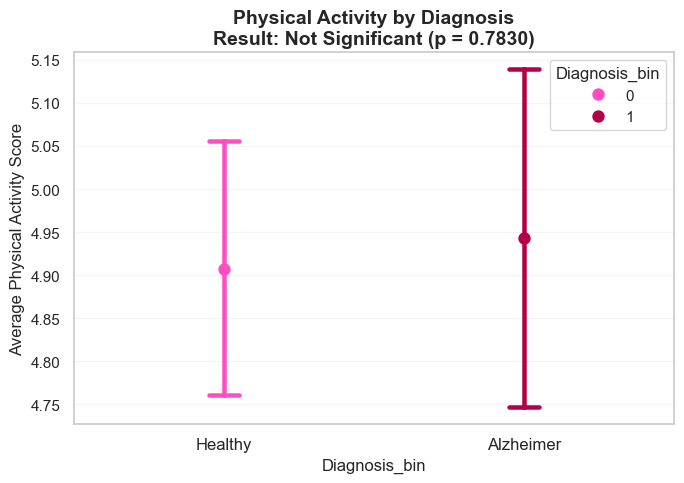

In [21]:
#Statistical Analysis:We used an Independent T-test because we are comparing the means of two independent groups 
#(Healthy vs. Alzheimer) to determine if the difference in their Physical Activity is 
#statistically significant.
#It is imporatant to note, that the physical activity is tested when the people with AD already know about the disease,
#so it does not answer our hypothesis, but the reasult is not significant.

group_healthy = df[df['Diagnosis_bin'] == 0]['PhysicalActivity']
group_alzheimer = df[df['Diagnosis_bin'] == 1]['PhysicalActivity']
t_stat, p_val = stats.ttest_ind(group_healthy, group_alzheimer)

is_significant = p_val < 0.05
status_text = "Significant" if is_significant else "Not Significant"

plt.figure(figsize=(7, 5))

ax = sns.pointplot(
    data=df, 
    x='Diagnosis_bin', 
    y='PhysicalActivity', 
    hue='Diagnosis_bin',
    palette=[PALETTE[1], PALETTE[0]], 
    join=False,       
    capsize=.1,       
    scale=1.2         
)

#Setting the Title with the Statistical Result integrated
plt.title(f"Physical Activity by Diagnosis\nResult: {status_text} (p = {p_val:.4f})", 
          fontsize=14, fontweight='bold')

plt.xticks([0, 1], ['Healthy', 'Alzheimer'], fontsize=12)
plt.ylabel("Average Physical Activity Score", fontsize=12)

plt.grid(axis='y', alpha=0.2) 
plt.tight_layout()
plt.show()

Hypothesis 2:
Our goal here is to find if more educated people have a lower chance of developing Alzheimer's disease.
We expect to find a "protective effect" of education, where higher education levels correlate with higher MMSE scores, potentially delaying clinical symptoms.

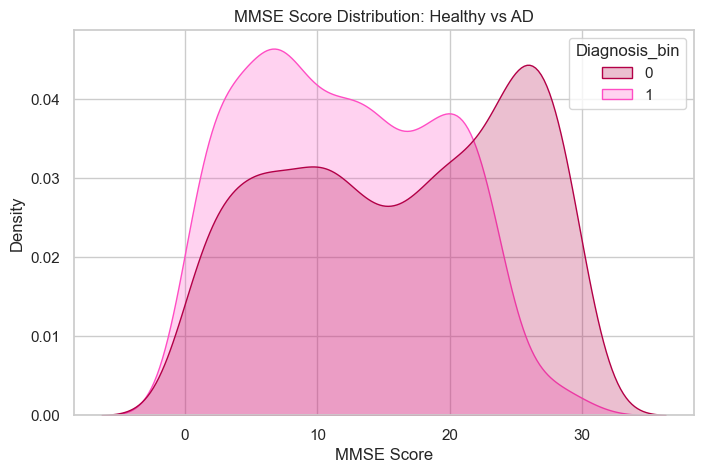

In [22]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x="MMSE", hue="Diagnosis_bin", fill=True, palette=PALETTE[:2], common_norm=False)
plt.title("MMSE Score Distribution: Healthy vs AD")
plt.xlabel("MMSE Score")
plt.ylabel("Density")
plt.show()

---
## Mean MMSE by EducationLevel
---

C:\Users\Hanna\AppData\Local\Temp\ipykernel_6236\1277451778.py:6: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(


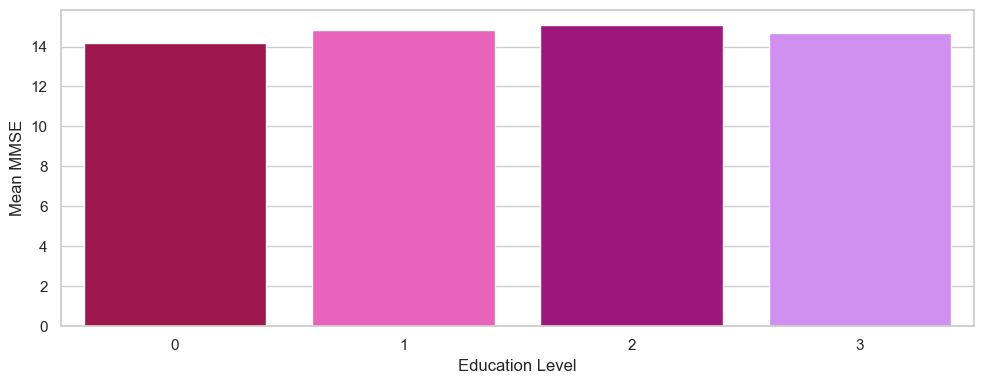

In [23]:
section("Mean MMSE by EducationLevel")
# Barplot of mean MMSE per education category (very easy to interpret)
mean_mmse = df.groupby("EducationLevel", dropna=False)["MMSE"].mean().reset_index()

plt.figure(figsize=(10,4))
sns.barplot(
    data=mean_mmse,
    x="EducationLevel",
    y="MMSE",
    hue="EducationLevel",
    palette=PALETTE,
    legend=False
)
plt.xlabel("Education Level")
plt.ylabel("Mean MMSE")
plt.tight_layout()
plt.show()
#this is the easier graph version for understanding.

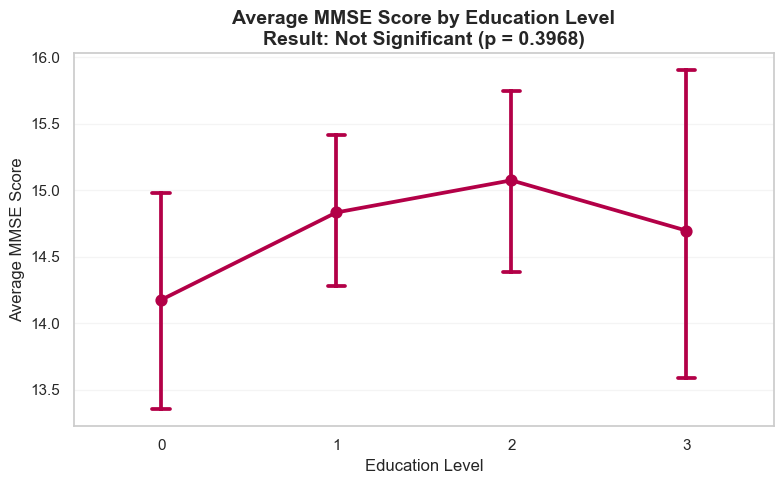

In [24]:
#We used ANOVA because we are compared means across more than two groups (Education Levels: 0, 1, 2, 3).
#This checks if at least one group mean is significantly different from the others.

education_groups = [df[df['EducationLevel'] == i]['MMSE'] for i in sorted(df['EducationLevel'].unique())]
f_stat, p_val = stats.f_oneway(*education_groups)

is_significant = p_val < 0.05
status_text = "Significant" if is_significant else "Not Significant"

plt.figure(figsize=(8, 5))

#point plot graph
sns.pointplot(    
    data=df, 
    x='EducationLevel', 
    y='MMSE', 
    color=PALETTE[0], 
    capsize=.1,      # Adding caps to the error bars
    markers="o",     # Circular marker for the mean point  
    linestyles="-"   # Connecting the points with a line to show the trend
)

#Setting the Title with the ANOVA Result integrated
plt.title(f"Average MMSE Score by Education Level\nResult: {status_text} (p = {p_val:.4f})", 
          fontsize=14, fontweight='bold')

plt.xlabel("Education Level", fontsize=12)
plt.ylabel("Average MMSE Score", fontsize=12)

plt.grid(axis='y', alpha=0.2) 
plt.tight_layout()
plt.show()

hypothesis 3:
The connection between Average Sleep Quality to Memory Complaints:

Our goal here is to investigate whether poor sleep quality scores are linked to an increase in subjective memory complaints among non-diagnosed individuals.

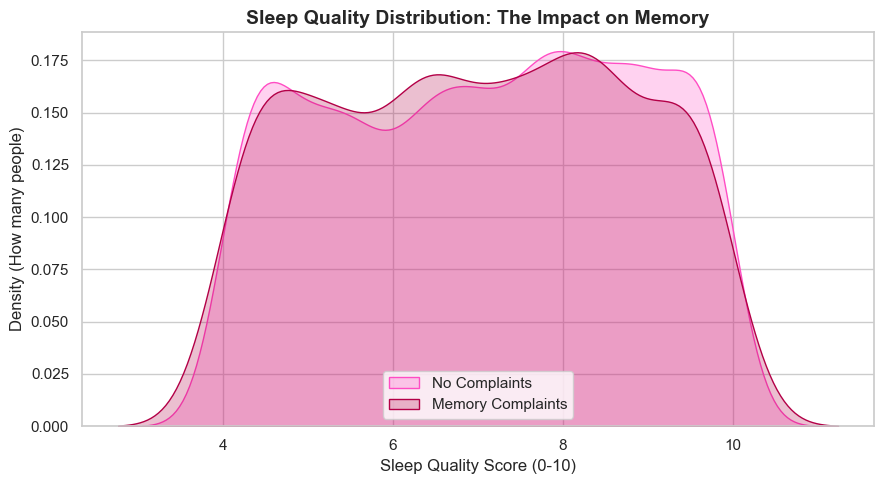

In [25]:
plt.figure(figsize=(9, 5))

sns.kdeplot(data=df[df['MemoryComplaints_bin'] == 0]['SleepQuality'], 
            fill=True, color=PALETTE[1], label='No Complaints', bw_adjust=0.8)

sns.kdeplot(data=df[df['MemoryComplaints_bin'] == 1]['SleepQuality'], 
            fill=True, color=PALETTE[0], label='Memory Complaints', bw_adjust=0.8)

plt.title("Sleep Quality Distribution: The Impact on Memory", fontsize=14, fontweight='bold')
plt.xlabel("Sleep Quality Score (0-10)", fontsize=12)
plt.ylabel("Density (How many people)", fontsize=12)

plt.legend()#יצירת מקרא

plt.tight_layout()#automatically adjust spacing in the graph.
plt.show()

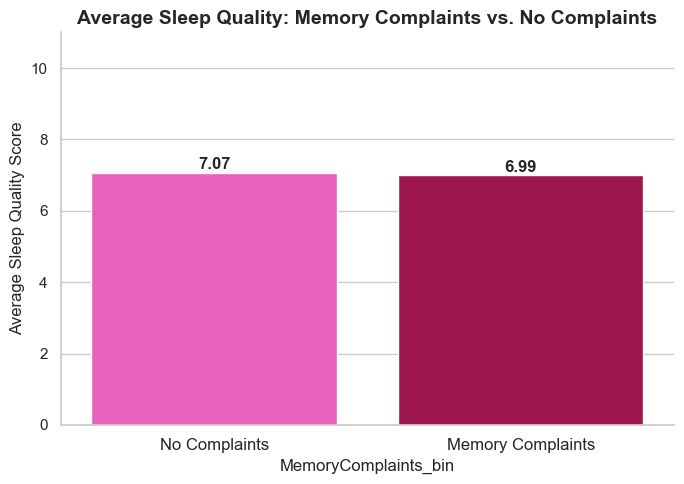

In [26]:
plt.figure(figsize=(7, 5))

#caalculating the mean.
sleep_means = df.groupby('MemoryComplaints_bin')['SleepQuality'].mean()

sns.barplot(
    x=sleep_means.index, 
    y=sleep_means.values, 
    palette=[PALETTE[1], PALETTE[0]],
    hue=sleep_means.index,
    legend=False
)

plt.title("Average Sleep Quality: Memory Complaints vs. No Complaints", fontsize=14, fontweight='bold')
plt.xticks([0, 1], ['No Complaints', 'Memory Complaints'], fontsize=12)
plt.ylabel("Average Sleep Quality Score", fontsize=12)
plt.ylim(0, df['SleepQuality'].max() + 1)
#The last line makes sure the graph starts from 0.

#Adding the average on top.
for i, v in enumerate(sleep_means.values):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()